In [1]:
import lightning as L
import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd

import torch_deeplabv3 as dlv3

In [2]:
model = dlv3.LitDeepLabV3.load_from_checkpoint(
    "lightning_logs/version_45/checkpoints/epoch=19-step=840.ckpt",
    n_ch=15, ens_prediction=True                                              
)
model

LitDeepLabV3(
  (model): DeepLabV3(
    (model): DeepLabV3(
      (backbone): IntermediateLayerGetter(
        (conv1): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0

In [3]:
_, _, test_loader = dlv3.get_loaders(kf_weighing=False, batch_size=32)

In [4]:
X, y = zip(*(batch for batch in tqdm.tqdm(test_loader)))
X = torch.concat(X)
y = torch.concat(y)
X.shape, y.shape

100%|██████████████████████████████████████| 27/27 [00:10<00:00,  2.51it/s]


(torch.Size([846, 15, 350, 350]), torch.Size([846, 350, 350]))

In [5]:
trainer = L.Trainer(devices=1, logger=False)
trainer.test(model, test_loader)

/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/max/mambaforge/envs/keras3/lib/python3.11/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████| 27/27 [00:29<00:00,  0.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.6378984451293945     │
│         test_loss         │    0.4411850869655609     │
│        test_nz_std        │   0.0014156399993225932   │
└───────────────────────────┴───────────────────────────┘

[{'test_nz_std': 0.0014156399993225932,
  'test_loss': 0.4411850869655609,
  'test_dice': 0.6378984451293945}]

# PFI

In [6]:
def shuffle_channel(data, channel):
    """Shuffle the data in a specific channel."""
    # Clone the data to avoid modifying the original dataset
    shuffled_data = data.clone()
    # Shuffle each image in the batch separately to maintain independence
    for i in range(shuffled_data.shape[0]):
        shuffled_data[i, channel] = shuffled_data[i, channel].flatten()[
            torch.randperm(shuffled_data[i, channel].nelement())
        ].view(
            shuffled_data[i, channel].shape
        )
        
    return shuffled_data

In [7]:
def get_Xy_loader(X, y, **kwargs):
    if y is None:
        ds = [(Xi, None) for Xi in X]
    else:
        ds = list(zip(X, y))
    return torch.utils.data.DataLoader(ds, **kwargs)

In [8]:
# Only one batch for now
# X, y = next(iter(test_loader))
# X.shape, y.shape

X, y = zip(*(batch for batch in tqdm.tqdm(test_loader)))
X = torch.concat(X)
y = torch.concat(y)
X.shape, y.shape

100%|██████████████████████████████████████| 27/27 [00:10<00:00,  2.67it/s]


(torch.Size([846, 15, 350, 350]), torch.Size([846, 350, 350]))

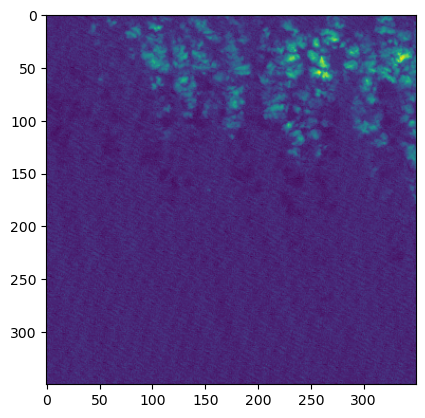

In [9]:
plt.imshow(X[0, 0])

In [10]:
X_shuf = shuffle_channel(X[:2], 1)

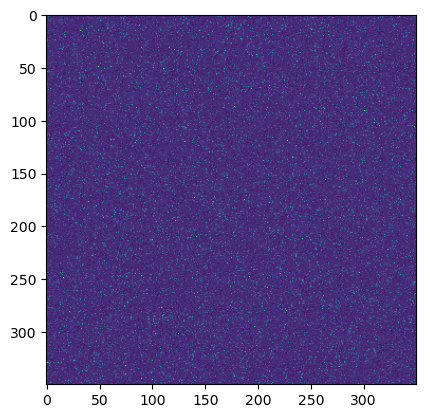

In [11]:
plt.imshow(X_shuf[0, 1])

In [12]:
trainer = L.Trainer(devices=1, logger=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
score_baseline = trainer.test(model, get_Xy_loader(X, y, batch_size=32))[0]
score_baseline

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.6378984451293945     │
│         test_loss         │    0.4411850869655609     │
│        test_nz_std        │   0.0014156399993225932   │
└───────────────────────────┴───────────────────────────┘

{'test_nz_std': 0.0014156399993225932,
 'test_loss': 0.4411850869655609,
 'test_dice': 0.6378984451293945}

In [ ]:
scores_perm = []
for i in range(model.n_ch):
    X_perm = shuffle_channel(X, i)
    scores_perm.append(
        trainer.test(model, get_Xy_loader(X_perm, y, batch_size=32))[0]
    )

# Make scores relative to baseline
for i, scores_perm_ch in enumerate(scores_perm):
    for k in score_baseline:
        scores_perm[i][k] /= score_baseline[k]

fi_df = pd.DataFrame(scores_perm)
fi_df["test_dice"] = 1 - fi_df["test_dice"]  # performance drop = important
fi_df["test_nz_std"] = fi_df["test_nz_std"] - 1 # more uncertainty = important

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.31it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.5362855792045593     │
│         test_loss         │    0.5301118493080139     │
│        test_nz_std        │   0.001328239100985229    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.5860736966133118     │
│         test_loss         │    0.48932093381881714    │
│        test_nz_std        │   0.001176745630800724    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.5739977955818176     │
│         test_loss         │    0.49585872888565063    │
│        test_nz_std        │   0.0014638720313087106   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.5856894850730896     │
│         test_loss         │    0.48335570096969604    │
│        test_nz_std        │   0.0014910709578543901   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.6100848913192749     │
│         test_loss         │    0.4675019681453705     │
│        test_nz_std        │   0.0012319765519350767   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.6202957630157471     │
│         test_loss         │    0.45772576332092285    │
│        test_nz_std        │   0.0013151462189853191   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.30874645709991455    │
│         test_loss         │    0.7339135408401489     │
│        test_nz_std        │   0.0005805082037113607   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.31712856888771057    │
│         test_loss         │    0.7263022661209106     │
│        test_nz_std        │   0.0005957001121714711   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.49820801615715027    │
│         test_loss         │    0.5599168539047241     │
│        test_nz_std        │   0.002370713744312525    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.12211351096630096    │
│         test_loss         │    0.8874022364616394     │
│        test_nz_std        │   0.0005399078945629299   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.5310693383216858     │
│         test_loss         │    0.5322787761688232     │
│        test_nz_std        │   0.0022185032721608877   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0: 100%|████████████████| 27/27 [00:20<00:00,  1.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.5484684705734253     │
│         test_loss         │    0.5173593759536743     │
│        test_nz_std        │   0.0023173277731984854   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing DataLoader 0:  33%|█████▋           | 9/27 [00:07<00:14,  1.27it/s]

In [ ]:
fi_df["test_dice"].plot.bar()

In [ ]:
fi_df["test_nz_std"].plot.bar()

# Ensemble

In [5]:
trainer = L.Trainer(devices=1, logger=False)
y_hat = trainer.predict(model, test_loader)
y_hat = torch.concat(y_hat)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 27/27 [00:43<00:00,  0.62it/s]


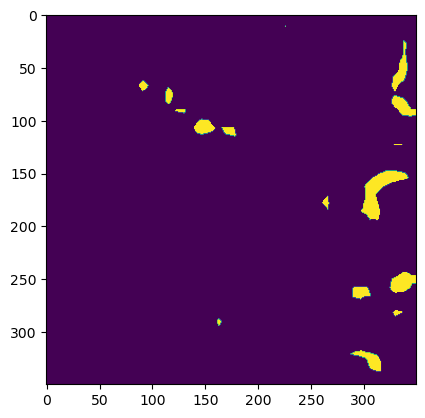

In [6]:
plt.imshow(y_hat[3])

In [8]:
plt.imshow(y[3])

NameError: name 'y' is not defined

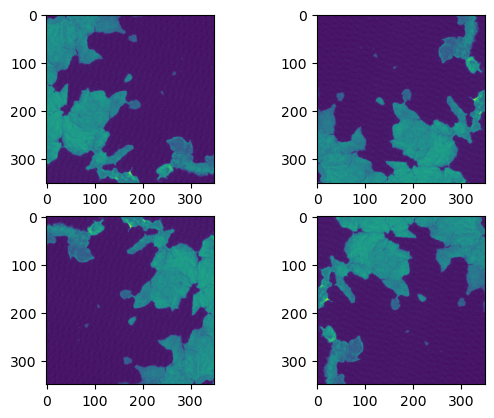

In [7]:
Xi = X[3]
Xrot = [
    torch.rot90(Xi, k=k, dims=[1, 2])
    for k in [0, 1, 2, 3]
]

fig, axarr = plt.subplots(ncols=2, nrows=2)
for i, ax in enumerate(axarr.ravel()):
    ax.imshow(Xrot[i][0])

In [8]:
def get_X_loader(X):
    ds = [(Xi, 0) for Xi in X]
    return torch.utils.data.DataLoader(ds)

In [9]:
y_hat = trainer.predict(model, get_X_loader(Xrot))
y_hat = torch.concat(y_hat).float()

# Rotate predictions back
y_hat = torch.stack([
    torch.rot90(y_hat[i], k=-i)
    for i in range(len(y_hat))
])

y_hat.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|████████████| 4/4 [00:00<00:00, 36.96it/s]


torch.Size([4, 350, 350])

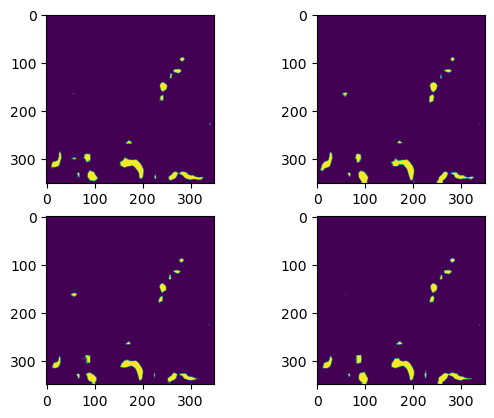

In [10]:
fig, axarr = plt.subplots(ncols=2, nrows=2)
for i, ax in enumerate(axarr.ravel()):
    ax.imshow(y_hat[i])

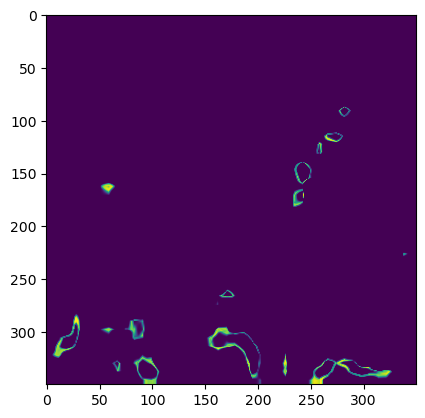

In [11]:
plt.imshow(y_hat.std(axis=0))

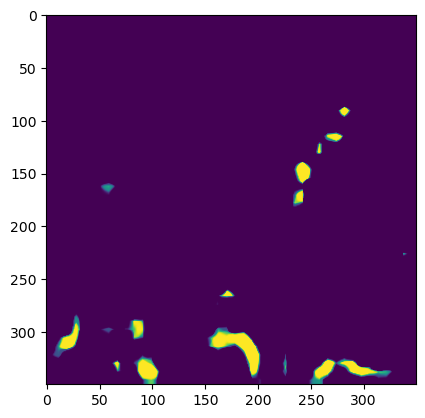

In [15]:
plt.imshow(y_hat.mean(axis=0))